#### Imports and utilities

In [1]:
%load_ext autoreload
%autoreload 2

import sys
# change this to suit your path
sys.path.append('/home/guillaume/Python/kt_simul/')

In [2]:
import IPython.display as disp

from sympy import symbols, Matrix
from sympy import sympify
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.mechanics import ReferenceFrame, Point, Particle
from sympy.physics.mechanics import LagrangesMethod, Lagrangian, KanesMethod

from sympy.physics.mechanics import mechanics_printing
mechanics_printing(pretty_print=True) # Shinny

from collections import defaultdict
from kt_simul.smp_spindle.smp_spindle import SympySpindle
from kt_simul.smp_spindle.forces import DampedSpring, LinearFV, ViscousDrag

def indexer(name, index=None, expo=None):
    '''Small utility to append an index  and
    an exponent to the string `name`
    '''
    if index is not None:
        name = name + '_' + index
    if expo is not None:
        name = name + '^' + expo
    return name

# A dumb spindle in sympy

In [3]:
spindle = SympySpindle('Dumb')


### Model description

We're looking at a simple mechanical system

![dumb spindle](dumb_spindle.svg)


#### Particles and positions

_correct for bad order_
We have $x_{sL}, x_{sR}, x_{kA}, x_{kB},  x_{cA}, x_{cB}$ the positions of left and right spindle pole bodies, A & B attachment sites (aka the kinetochore), A & B centromeres, respectively.





In [4]:
#### Spindle referential frame coordinates (1D)
xs = x_s, x_cA, x_kA, x_cB, x_kB = dynamicsymbols("x_s, x_cA, x_kA, x_cB, x_kB")

## Speeds
xds = x_sd, x_cAd, x_kAd, x_cBd, x_kBd = dynamicsymbols("x_s, x_cA, x_kA, x_cB, x_kB", 1)


## Independant generalized coordinates

* $L$ - the spindle length
* $c_n$ - position of the chromosome center 
* $l_n$ - the distance between centromere A and centromere B.
  Note that $l_n$ is *corrected for the equilibrium distance* between the centromeres,
   such that $l_n = x_A - x_B - d_0$, where $x_0$ is the rest length of the cohesin spring.
* $d_A$, $d_B$ - the distance between centromere A and attachment site A (resp. B) 

Generalized speeds are simply the time derivatives of the above coordinates.


We'll describe the dependant coordinates below while defining the forces



In [5]:
### independant generalized coordinates
q_ind = L, c_n, l_n, d_A, d_B = dynamicsymbols('L, c_n, l_n, d_A, d_B')
### generalized speeds (coordinates derivatives)
qd_ind = Ld, c_nd, l_nd, d_Ad, d_Bd = dynamicsymbols('L, c_n, l_n, d_A, d_B', 1)

### generalized speed - Kanes formalism
u_ind = vL, vc_n, vl_n, vd_A, vd_B = dynamicsymbols('^vL, ^vc_n, ^vl_n, ^vd_A, ^vd_B')


### Register in the container
spindle.q_ind = q_ind
spindle.qd_ind = qd_ind

### Kanes method
spindle.u_ind = u_ind

### Kinematics
spindle.kd.extend((qd - u for (qd, u) in
                   zip(qd_ind, u_ind)))


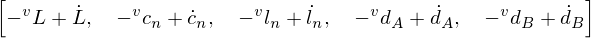

In [6]:
spindle.kd

#### Transformation matrix from independant generalized to original coordinates


We write matrix T such that $q = Tx$ or $T^{-1}q = x$, which we check below. 

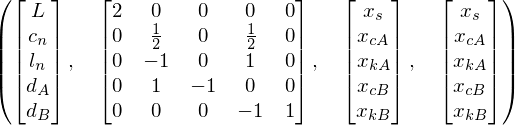

In [7]:
### Substitutions to come back to the original variables (assuming d_0 = 0 for simplicity)
to_subs = [(L, 2*x_s),
           (c_n, x_cB/2 + x_cA/2),
           (l_n, x_cB - x_cA),
           (d_A, x_cA - x_kA),
           (d_B, x_kB - x_cB)]

### Corresponding transition matrix
trans = Matrix([[4,  0,  0,  0, 0],
                [0,  1,  0,  1, 0],
                [0, -2,  0,  2, 0],
                [0,  2, -2,  0, 0],
                [0,  0,  0, -2, 2]]) / 2

### Check we're back on our feets
back_transform = trans.inv().multiply(Matrix(q_ind)).subs(to_subs)
assert Matrix(xs) == back_transform

Matrix(q_ind), trans,  Matrix(xs), back_transform

### Parameters

#### Dambed springs

In [8]:
### Chromatin
kappa_c, d_0, mu_c = symbols("kappa_c, d_0, mu_c")
### Kinetochore - centromere
kappa_k, mu_k = symbols("kappa_k, mu_k")

#### Viscous drags

In [9]:
### Chromosomes
mu_ch =  symbols("mu_ch")
### SPBs
mu_s = symbols("mu_s")

#### Force velocity

In [10]:
### Interdigitated microtubules
F_mz, V_mz =  symbols("F_mz, V_mz")
### kinteochore microtubules
F_k, V_k =  symbols("F_k, V_k")

## Points and Reference frame

* $S$ is a simple 1D reference frame
* spc - spindle center - the origin
* spb - spindle pole bodies
* ch - chromosome centers
* cen - centromeres
* as - attachment sites

Below we define them and set a position and a speed for each

In [11]:
S = ReferenceFrame('S')
spindle.referenceframe = S

## spindle center
spc = Point('spc')
spc.set_vel(S, 0)

### Spindle pole bodies
spbR = spc.locatenew('spbR', L * S.x / 2)
spbR.set_vel(S, vL * S.x / 2)
             
spbL = spc.locatenew('spbL', -L * S.x / 2)
spbL.set_vel(S, -vL * S.x / 2)

### Chromosomes
ch = spc.locatenew('ch', c_n * S.x)
ch.set_vel(S, vc_n * S.x)

### centromere and attachment site A
cenA = ch.locatenew('cenA', -(l_n + d_0)/2 * S.x)
cenA.set_vel(S, ch.vel(S) - vl_n/2 * S.x)

as_A = cenA.locatenew('as_A', - d_A * S.x)
as_A.set_vel(S, cenA.vel(S) - vd_A * S.x)

### centromere and attachment site A
cenB = ch.locatenew('cenB', (l_n + d_0)/2 * S.x)
cenB.set_vel(S, ch.vel(S) + vl_n/2 * S.x)

as_B = cenB.locatenew('as_B', d_B * S.x)
as_B.set_vel(S, cenB.vel(S) + vd_B * S.x)


spindle.points = [spbR, spbL, ch, cenA, as_A, cenB, as_B]

#### access a relative speed

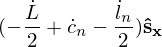

In [12]:
v_AR = cenA.pos_from(spbR).dt(S)
## uncomment to project along S.x 
#v_AR = v_AR & S.x
v_AR

## Forces and energies

### Viscous drag

* Spindle length:
$$F^r_s = -\mu_s \dot{L}$$

* Chromosome:
$$F^r_{ch} = -\mu_{ch} \dot{c_n}$$


### Damped springs

* Centromere pair
$$F^s_c = \kappa_c l_n - \mu_c \dot{l_n}$$

* Kinetochore (cenA)
$$F^s_k = \kappa_k d_A - \mu_k \dot{d_A}$$
Note that all equations are identical for A and B.


This is implemented in the class DampedSpring

In [13]:
print(DampedSpring.new.__doc__)


Adds an over-damped spring in `spindle`

        Parameters
        ----------
        spindle: a :class:`kt_simul.SympySpinde` instance
        length : dynamicsymbol
          the extension of the spring corrected for eq. distance.
        lengthd : dynamicsymbol
          the damped speed
        kappa : Young modulus
        mu : friction coefficient
        poitn1, point2: extremities of the spring
        e_F : unit vector allong the force axis
        


### Linear force-velocity relationship

#### Definition

A linear force velocity relationship is used to model the traction exerted 
by molecular motors between two objects. We have:

$$ F = F_{max} \gamma ( 1 -  \frac{u2 - u1}{V_{max}}) \mathbf{e}_F $$

where $F_{max}$ is the stall force and $V_{max}$ the maximum speed (in the intended regime).


For each of the motors, we define the generalized distance and the generalized speed associated.

In [14]:
print(LinearFV.__doc__)


    Linear Force velocity relationship
    F = F_max(1 - gamma * (u2 - u1)/V_max)e_F

        p1      p2
          .____.
       <--     -->
        -F      F gamma = 1

        -->   <--
        -F      F gamma = -1

    Attributes
    ----------

    F : force vector
    v: expression
         the relative speed of point2 wrt to point 1

    We have
    ..math:
        F = \gamma F_{max} ( 1 - rac{v}{V_{max}})

    


### Application to the spindle

In [15]:
### reset forces
spindle.forces = []

spring_ch = DampedSpring.new(spindle, S, cenA, cenB,
                             kappa_c, mu_c, d_0, e_F=S.x)

spring_cA = DampedSpring.new(spindle, S, as_A, cenA,
                             kappa_k, mu_k, 0, e_F=S.x)

spring_cB = DampedSpring.new(spindle, S, as_B, cenB,
                             kappa_k, mu_k, 0, e_F=-S.x)

## Frictions
viscous_spbL = ViscousDrag.new(spindle, S, spbL, mu_s)
viscous_spbR = ViscousDrag.new(spindle, S, spbR, mu_s)

### just to be coherent with the original problem - maybe we can apply those forces to the entire chromosome
viscous_cenA = ViscousDrag.new(spindle, S, cenA, mu_ch)
viscous_cenB = ViscousDrag.new(spindle, S, cenB, mu_ch)


## Linear force velocity relationships

## Midzone (expanding)
lfv_mz = LinearFV.new(spindle, S,
                      spbL, spbR,
                      F_mz, V_mz, 1, e_F=S.x)
### attachment site A to spbL (retracting)
lfv_ktA = LinearFV.new(spindle, S,
                       spbL, as_A,
                       F_k, V_k, -1, e_F=S.x)

### attachment site B to spbR (retracting)
lfv_ktB = LinearFV.new(spindle, S,
                       spbR, as_B,
                       F_k, V_k, -1, e_F=-S.x)


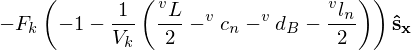

In [16]:
lfv_ktB.F

In [17]:
spring_ch.F_k

### Kanes Method

In [18]:
spindle.q_ind, spindle.u_ind

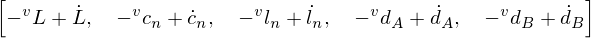

In [19]:
spindle.kd

In [27]:
spindle.points

[spbR, spbL, ch, cenA, as_A, cenB, as_B]

In [20]:
KM = KanesMethod(S, spindle.q_ind, spindle.u_ind, spindle.kd,)

In [21]:
particles = [Particle('p{}'.format(point.name), point, 0) # zero mass
             for point in set(spindle.points)]

(eoms, frstar) = KM.kanes_equations(spindle.forces,
                                    particles)

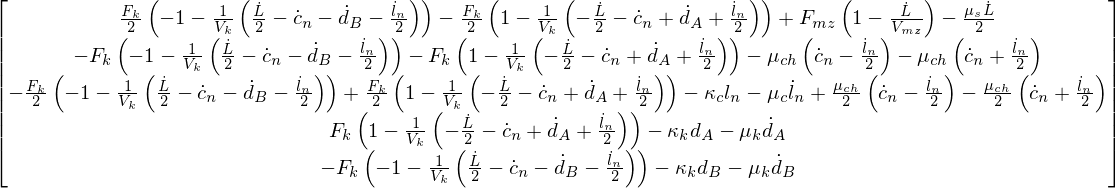

In [23]:
rev_kddict = {v:k for k, v in KM.kindiffdict().items()}
eoms.subs(rev_kddict)

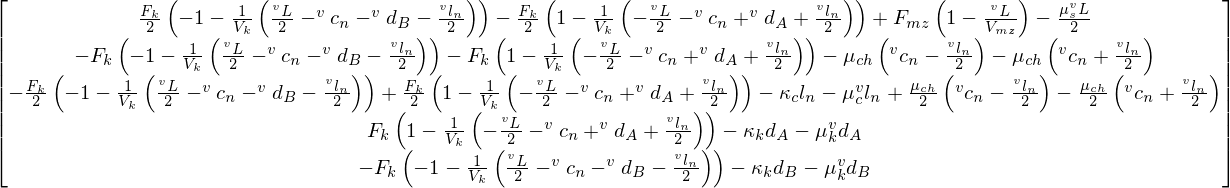

In [22]:
eoms

In [32]:
A_uu = eoms.jacobian(Matrix(spindle.u_ind))

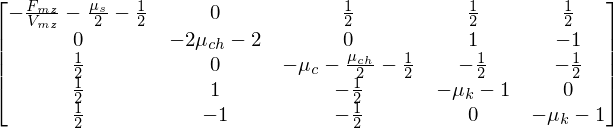

In [33]:
A_uu.subs({F_k:1, V_k:1})

In [34]:
A_vv = trans.T.multiply(A_uu.multiply(trans))

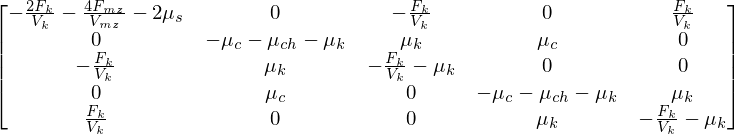

In [35]:
A_vv

In [36]:
B_qq = eoms.jacobian(Matrix(spindle.q_ind))

In [37]:
B_xx = trans.T.multiply(B_qq.multiply(trans))


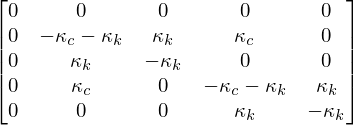

In [38]:
B_xx

In [39]:
u_zero = {u:0 for u in spindle.u_ind}
q_zero = {q:0 for q in spindle.q_ind}
C = eoms.subs(u_zero).subs(q_zero)


In [40]:
L.diff()

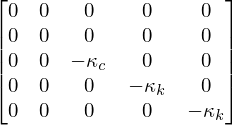

In [41]:
B_qq

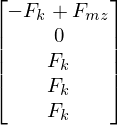

In [42]:
C

In [43]:
from sympy import solve

In [44]:
sol = solve(eoms.subs({F_k:1, V_k:1}), spindle.u_ind) 

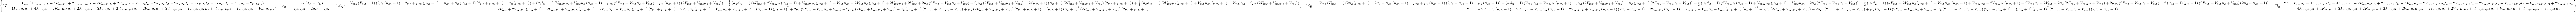

In [45]:
sol

In [46]:
from sympy import lambdify

In [47]:
A_args = [F_mz, V_mz, F_k, V_k, mu_s, mu_c, mu_ch, mu_k]

In [48]:
A_np = lambdify(A_args, A_uu, modules="numpy")

In [49]:
A_np?

In [51]:

Anp = A_np(1, 2, 3, 4, 5, 6, 7, 8)